In [372]:
%reset -f
import sys
print("Python version")
print(sys.version)

Python version
3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]


In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [374]:
#Coingecko api
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [375]:
import time
import datetime

def edit_prices_dict(d): 
    df=pd.DataFrame(d)
    #Saving dates
    dates=df['prices'].map(lambda x: x[0])  
    #Filtering the values without dates
    df=df.applymap(lambda x: x[1])
    df['dates']=dates 
    df["dates"] = pd.to_datetime(df['dates'], unit='ms')
    df.index = df["dates"]
    df=df[['prices','total_volumes']]
    return df

In [376]:
#dd/mm/yyyy
from_date="01/03/2021"
to_date="25/11/2021"
from_unix = time.mktime(datetime.datetime.strptime(from_date, "%d/%m/%Y").timetuple())
to_unix = time.mktime(datetime.datetime.strptime(to_date, "%d/%m/%Y").timetuple())

token = "bitcoin"; vs_currency = "usd"

response=cg.get_coin_market_chart_range_by_id(id = token, vs_currency = vs_currency, from_timestamp = from_unix, to_timestamp = to_unix)

In [377]:
df = edit_prices_dict(response)
print(df.shape)
df.tail()

(269, 2)


,prices,total_volumes
dates,,
2021-11-20,58459.255517,3.785126e+10
2021-11-21,60082.911668,2.967655e+10
2021-11-22,59139.779280,2.574343e+10
2021-11-23,56386.856853,3.400147e+10
2021-11-24,57748.793174,3.642119e+10


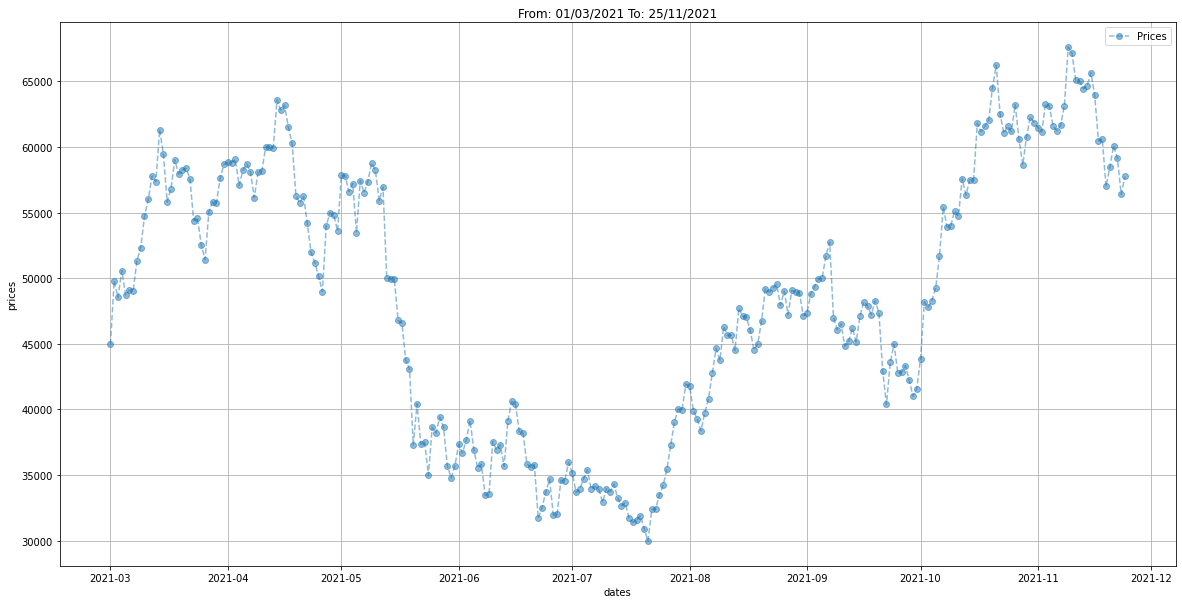

In [378]:
fig=plt.figure(figsize=(20, 10))
plt.plot(df['prices'], '--o', label = 'Prices', alpha = 0.5)
plt.title('From: ' + from_date + ' To: ' + to_date) 
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)

In [379]:
# Esto hay que hacerlo pues es con la info de hoy predecir mañana
lag_days = 1
df["y"] = df["prices"].shift(-1 * lag_days)
df.tail(5)

,prices,total_volumes,y
dates,,,
2021-11-20,58459.255517,3.785126e+10,60082.911668
2021-11-21,60082.911668,2.967655e+10,59139.779280
2021-11-22,59139.779280,2.574343e+10,56386.856853
2021-11-23,56386.856853,3.400147e+10,57748.793174
2021-11-24,57748.793174,3.642119e+10,NaN


#### Se calculan indicadores para ese día

In [380]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
#values_ma = [5,15,30]
#
#for i in values_ma:
#    df["ma_close_" + str(i)] = df["close"].rolling(window=i).mean()
#    df["ma_volume_" + str(i)] = df["volume"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["prices"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,14,21]
close = df['prices']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['prices'].rolling(window=i).mean() + (df['prices'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['prices'].rolling(window=i).mean() - (df['prices'].rolling(window=i).std()  * 2)

# Rate of change
values_rc = [5,15,30]
for i in values_rc:
    df["rc_" + str(i)] = df["prices"].pct_change(periods = i)
    
# Stochastic Oscillators
#values_so = [5,15,30]
#for i in values_so:
#    lowest = df["low"].rolling(window = i).min()
#    high = df["high"].rolling(window = i).max()
#    df["so_" + str(i)] = ((df['close'] -lowest)/(high - lowest))*100
#    df["so_%D" + str(i)] = df["so_" + str(i)].rolling(window = i).mean()

In [381]:
# Get feature from dates
#df['month'] = df.index.month.astype(str)
#df['day'] = df.index.day
#df['weekday'] = df.index.dayofweek.astype(str)
#df['dayofyear'] = df.index.dayofyear

In [382]:
df.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2021-09-30,41587.667862,3.006869e+10,43859.326147,42101.638488,43728.103591,44824.116254,35.940165,33.655919,41.920599,44082.924782,40332.721293,45230.481347,39905.313621,49648.762707,39659.325753,-0.027238,-0.117698,-0.117489


In [383]:
df["y"] = 100*( (df["y"] - df["prices"])/df["prices"])   
df.tail(1)

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2021-11-24,57748.793174,3.642119e+10,NaN,58303.193913,60355.513019,60582.94626,38.680219,27.686349,40.804333,61165.86434,55561.174256,65840.88554,54047.104549,68732.741026,55369.77309,0.013362,-0.145943,-0.055978


In [384]:
cota_max = 5
cota_min = -5

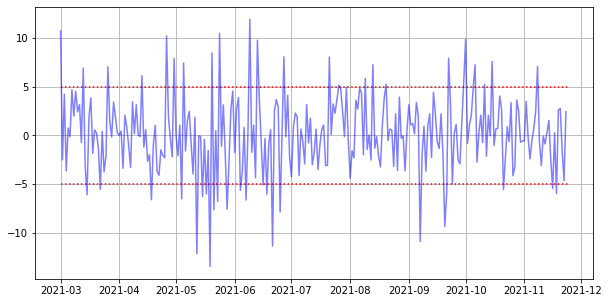

In [385]:
fig=plt.figure(figsize=(10, 5))
plt.plot(df['y'], 'b', label = 'Delta', alpha = 0.5)
plt.hlines(cota_max, df.index.min(), df.index.max(), color='r', ls=':')
plt.hlines(cota_min, df.index.min(), df.index.max(), color='r', ls=':')
plt.grid(True)

In [386]:
def conditions(x):
    if x > cota_max:
        return "Vender"
    elif x < cota_min:
        return "Comprar"
    else:
        return "Mantener"

func = np.vectorize(conditions)
df["y"] = func(df["y"])

In [387]:
df["y"].value_counts()

Mantener    222
Vender       24
Comprar      23
Name: y, dtype: int64

In [388]:
minus = 30 # Es el lag del pasado cuanto pillamos

In [389]:
df.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2021-06-09,33557.150683,4.672746e+10,Vender,34839.834573,36936.404491,40507.291194,32.360235,37.005408,37.038676,38100.968586,32030.51735,39738.459034,32641.790665,40721.372812,33035.110781,-0.142886,-0.131599,-0.423555


In [390]:
all_columns = list(df.columns)
keep_columns = [item for item in all_columns if item not in "y"]
print(keep_columns)

['prices', 'total_volumes', 'ema_5', 'ema_15', 'ema_30', 'rsi_sma_7', 'rsi_sma_14', 'rsi_sma_21', 'bollinger_upper_5', 'bollinger_lower_5', 'bollinger_upper_10', 'bollinger_lower_10', 'bollinger_upper_20', 'bollinger_lower_20', 'rc_5', 'rc_15', 'rc_30']


In [391]:
df.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30
dates,,,,,,,,,,,,,,,,,,
2021-11-11,65061.054407,4.864856e+10,Mantener,65063.974219,63231.827435,60894.89966,58.928141,67.978953,48.080604,70025.25448,59829.959017,68246.099571,58751.329383,66702.035791,58057.464818,0.062267,0.073541,0.130072


In [392]:
list_shift = list(range(1, minus))

for i in list_shift:
    for j in keep_columns:
        df[str(j) + "minus" + str(i)] = df[str(j)].shift(i)

In [393]:
print("Shape: " + str(df.shape))
df.dropna(inplace = True)
print("Shape: " + str(df.shape))

Shape: (269, 511)
Shape: (210, 511)


In [398]:
df.tail()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,rc_5minus1,rc_15minus1,rc_30minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,rc_5minus2,rc_15minus2,rc_30minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,rc_5minus3,rc_15minus3,rc_30minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,rc_5minus4,rc_15minus4,rc_30minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,rc_5minus5,rc_15minus5,rc_30minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,rc_5minus6,rc_15minus6,rc_30minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,rc_5minus7,rc_15minus7,rc_30minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,rc_5minus8,rc_15minus8,rc_30minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,rc_5minus9,rc_15minus9,rc_30minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,rc_5minus10,rc_15minus10,rc_30minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,rc_5minus11,rc_15minus11,rc_30minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,rc_5minus12,rc_15minus12,rc_30minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi

In [395]:
df.dtypes.value_counts()

float64    510
object       1
dtype: int64

In [399]:
df.shape

(210, 511)

In [400]:
train = df[0:200]
train.shape

(200, 511)

In [402]:
test = df[200:210]
print(test.shape)
test.tail(1)

(10, 511)


,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,rc_5,rc_15,rc_30,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,rc_5minus1,rc_15minus1,rc_30minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,rc_5minus2,rc_15minus2,rc_30minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,rc_5minus3,rc_15minus3,rc_30minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,rc_5minus4,rc_15minus4,rc_30minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,rc_5minus5,rc_15minus5,rc_30minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,rc_5minus6,rc_15minus6,rc_30minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,rc_5minus7,rc_15minus7,rc_30minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,rc_5minus8,rc_15minus8,rc_30minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,rc_5minus9,rc_15minus9,rc_30minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,rc_5minus10,rc_15minus10,rc_30minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,rc_5minus11,rc_15minus11,rc_30minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,rc_5minus12,rc_15minus12,rc_30minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi

In [405]:
# Importing module and initializing setup
from pycaret.classification import *

setup(data = train,
      target = 'y', feature_interaction=False,
      normalize=True, normalize_method="zscore",
      silent = True, verbose=False)

([('Setup Config',
                                  Description                               Value
   0                               session_id                                 569
   1                                   Target                                   y
   2                              Target Type                          Multiclass
   3                            Label Encoded  Comprar: 0, Mantener: 1, Vender: 2
   4                            Original Data                          (200, 511)
   5                           Missing Values                               False
   6                         Numeric Features                                 510
   7                     Categorical Features                                   0
   8                         Ordinal Features                               False
   9                High Cardinality Features                               False
   10                 High Cardinality Method                                No

In [406]:
best = compare_models(sort = 'AUC', exclude = ["catboost","knn"], verbose = False)

In [407]:
tuned_model = tune_model(best, optimize= "AUC", n_iter = 10, verbose = False)

In [ ]:
# finalize a model
    final_model = finalize_model(tuned_model)
    # Test
    test = df.iloc[i+past_t]
    test = pd.DataFrame(np.array(test).reshape(1, -1), columns = test.index)
    # generate predictions on unseen data

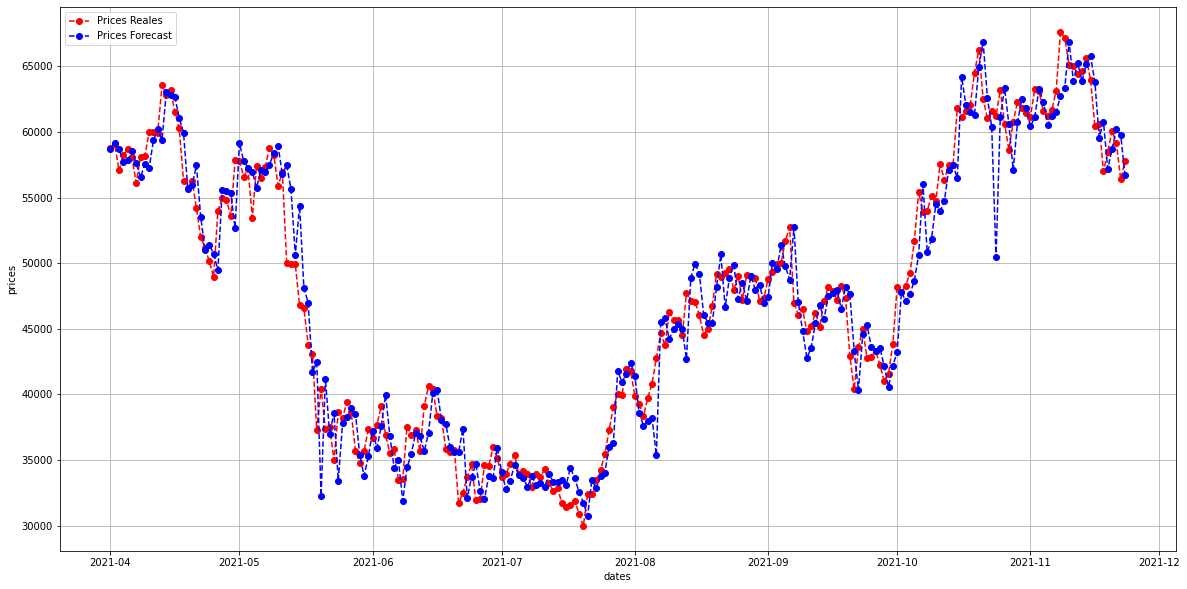

In [192]:
fig=plt.figure(figsize=(20, 10))
plt.plot(comparacion['y_real'], '--bo', label = 'Prices Reales', color = "r")
plt.plot(comparacion['y_pred'], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [194]:
comparacion.sample()

,y_real,y_pred
dates,,
2021-04-28,54810.613851,55533


In [ ]:
df["y_percentual"] = 100*( (df["y"] - df["prices"])/df["prices"])   
df.tail(4)

### Telegram

In [167]:
import telepot

bot_token = '1653124784:AAFpL0qlC_ybadcbFX6jKagauRFpiFpSf1E'
chatID = '-625272860'

bot = telepot.Bot(bot_token)

In [168]:
#ot.sendMessage(bot_chatID, "HALA")
bot.sendPhoto(chatID, photo=open('imagen.png', 'rb'))

{'message_id': 107,
 'from': {'id': 1653124784,
  'is_bot': True,
  'first_name': 'JARVIS',
  'username': 'JARVIS_Walkn_bot'},
 'chat': {'id': -625272860,
  'title': 'Trading',
  'type': 'group',
  'all_members_are_administrators': True},
 'date': 1637896017,
 'photo': [{'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADcwADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFReA',
   'file_size': 758,
   'width': 90,
   'height': 45},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADbQADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFRcg',
   'file_size': 9967,
   'width': 320,
   'height': 160},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADeAADIgQ',
   'file_unique_id': 'AQAD6LcxGxRjAAFRfQ',
   'file_size': 41074,
   'width': 800,
   'height': 400},
  {'file_id': 'AgACAgQAAxkDAANrYaBPUV6axk1vyzCmCRrt8HVu468AAui3MRsUYwABURgzD2eGDIwBAQADAgADeQADIgQ',
   'file_unique_id': 'AQAD